In [1]:
import numpy as np
import pandas as pd

from pythainlp import word_tokenize
from tqdm import tqdm_notebook
from pythainlp.ulmfit import process_thai

#viz
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import matplotlib
matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')

In [3]:
#import dataset for text file
'''
texts = []
labels = []
with open("wisesight-sentiment/kaggle-competition/train.txt",encoding="utf8") as f:
    for line in f:
        texts.append(line.strip())
        
with open("wisesight-sentiment/kaggle-competition/train_label.txt",encoding="utf8") as f:
    for line in f:
        labels.append(line.strip())

all_df = pd.DataFrame({"texts":texts,"category":labels})
all_df.shape
all_df.category.value_counts() / all_df.shape[0]
all_df = all_df[all_df.category != 'q'
all_df.to_csv('all_df.csv',index=False)
'''

'\ntexts = []\nlabels = []\nwith open("wisesight-sentiment/kaggle-competition/train.txt",encoding="utf8") as f:\n    for line in f:\n        texts.append(line.strip())\n        \nwith open("wisesight-sentiment/kaggle-competition/train_label.txt",encoding="utf8") as f:\n    for line in f:\n        labels.append(line.strip())\n\nall_df = pd.DataFrame({"texts":texts,"category":labels})\nall_df.shape\nall_df.category.value_counts() / all_df.shape[0]\nall_df = all_df[all_df.category != \'q\'\nall_df.to_csv(\'all_df.csv\',index=False)\n'

In [4]:
from pythainlp.ulmfit import *
process_thai("บ้านนนนน ()อยู่นานนานนาน 😂🤣😃😄😅 PyThaiNLP amp;     www.google.com")

['บ้าน',
 'xxrep',
 'อยู่',
 'xxwrep',
 'นาน',
 '😂',
 '🤣',
 '😃',
 '😄',
 '😅',
 'pythainlp',
 '&',
 'xxurl']

In [5]:
#import dataset
all_df = pd.read_csv('all_df.csv')
all_df.shape
all_df.category.value_counts() / all_df.shape[0]

neu    0.556594
neg    0.260777
pos    0.182629
Name: category, dtype: float64

In [6]:
#import independent dataset
'''
with open("wisesight-sentiment-master/kaggle-competition/test.txt",encoding="utf8") as f:
    texts = [line.strip() for line in f.readlines()]

test_df = pd.DataFrame({"category":"test", "texts":texts})
test_df.shape
test_df.to_csv('test_df.csv',index=False)
'''

test_df = pd.read_csv('test_df.csv')
test_df.shape

(2674, 2)

In [7]:
# preprocess the dataset ,tokenize the word
all_df["processed"] = all_df.texts.map(lambda x: "|".join(process_thai(x)))
all_df["wc"] = all_df.processed.map(lambda x: len(x.split("|")))
all_df["uwc"] = all_df.processed.map(lambda x: len(set(x.split("|"))))

test_df["processed"] = test_df.texts.map(lambda x: "|".join(process_thai(x)))
test_df["wc"] = test_df.processed.map(lambda x: len(x.split("|")))
test_df["uwc"] = test_df.processed.map(lambda x: len(set(x.split("|"))))

In [8]:
#prevalence
all_df.category.value_counts() / all_df.shape[0]

neu    0.556594
neg    0.260777
pos    0.182629
Name: category, dtype: float64

In [9]:
#80/20 random train/test split
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_df, test_size=0.20, random_state=101)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

In [10]:
valid_df.head()

,texts,category,processed,wc,uwc
0,ครั้งแรกในโลก! Hyundai ผุดไอเดียผลิตถุงลมนิรภั...,neu,ครั้งแรก|ใน|โลก|!|hyundai|ผุด|ไอเดีย|ผลิต|ถุงล...,15,15
1,แสดงว่ารถตู้วิน กับอัลติสแท๊กซี่เป็นรถยุโรปราค...,neg,แสดงว่า|รถตู้|วิน|กับ|อัลติส|แท๊กซี่|เป็น|รถ|ย...,10,10
2,อุ๊ยดีค่ะ ดีทั้งใหม่ ทั้งลอลีเอะเลย ร้องดี ใช้ดี,pos,อุ๊ย|ดี|ค่ะ|ดี|ทั้ง|ใหม่|ทั้ง|ลอ|ลี|เอะ|เลย|ร้...,15,11
3,บอกเลยพรรคอนาคตใหม่เป็นตัวแปรสำคัญมากๆที่ฝ่ายเ...,neu,บอก|เลย|พรรค|อนาคต|ใหม่|เป็น|ตัวแปร|สำคัญ|มาก|...,63,54
4,พารุ่นเล็กไปเจอรุ่นใหญ่ 😂😂😂,neu,พา|รุ่น|เล็ก|ไป|เจอ|รุ่น|ใหญ่|xxwrep|😂,9,8


In [11]:
#prevalence
train_df["category"].value_counts() / train_df.shape[0]

neu    0.557815
neg    0.260565
pos    0.181620
Name: category, dtype: float64


In [12]:
#prevalence
valid_df["category"].value_counts() / valid_df.shape[0]

neu    0.551709
neg    0.261627
pos    0.186664
Name: category, dtype: float64

In [13]:
#dependent variables
y_train = train_df["category"]
y_valid = valid_df["category"]

In [14]:
#text faetures
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

tfidf = TfidfVectorizer(tokenizer=process_thai, ngram_range=(1,2), min_df=20, sublinear_tf=True)
tfidf_fit = tfidf.fit(all_df["texts"])
text_train = tfidf_fit.transform(train_df["texts"])
text_valid = tfidf_fit.transform(valid_df["texts"])
text_test = tfidf_fit.transform(test_df["texts"])
text_train.shape, text_valid.shape

C:\Users\60050204\Anaconda3\envs\BigData\lib\site-packages\sklearn\feature_extraction\text.py:484: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


((18836, 4563), (4709, 4563))

In [15]:
#visualize texts
from visualize import top_feats_all, plot_top_feats
features = tfidf_fit.get_feature_names()
%time ts = top_feats_all(text_train.toarray(), y_train, features)
print(ts[0].shape)
ts[0].head()

Wall time: 1.27 s
(4563, 5)


,rank,feature,score,ngram,label
0,0,ไม่,0.029797,1,neg
1,1,กิน,0.023236,1,neg
2,2,xxrep,0.022239,1,neg
3,3,เลย,0.019928,1,neg
4,4,ก็,0.018650,1,neg


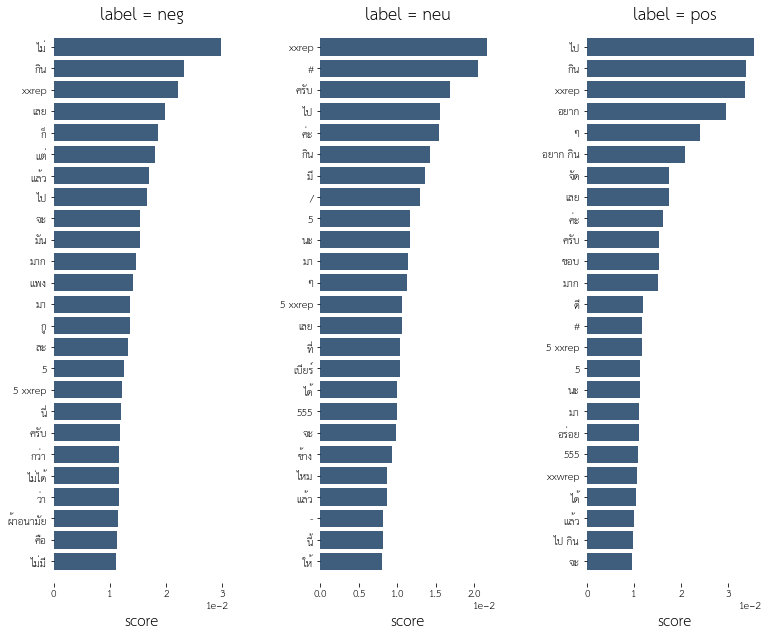

Wall time: 775 ms


In [16]:
%time plot_top_feats(ts)

In [17]:
#word count and unique word counts
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler_fit = scaler.fit(all_df[["wc","uwc"]].astype(float))
print(scaler_fit.mean_, scaler_fit.var_)
num_train = scaler_fit.transform(train_df[["wc","uwc"]].astype(float))
num_valid = scaler_fit.transform(valid_df[["wc","uwc"]].astype(float))
num_test = scaler_fit.transform(test_df[["wc","uwc"]].astype(float))
num_train.shape, num_valid.shape

[22.13221491 18.34330006] [1166.0826254   520.01860716]


((18836, 2), (4709, 2))

In [18]:
#concatenate text and word count features
X_train = np.concatenate([num_train,text_train.toarray()],axis=1)
X_valid = np.concatenate([num_valid,text_valid.toarray()],axis=1)
X_test = np.concatenate([num_test,text_test.toarray()],axis=1)
X_train.shape, X_valid.shape

((18836, 4565), (4709, 4565))

In [19]:
#fit logistic regression models
model = LogisticRegression(C=2., penalty="l2", solver="liblinear", dual=False, multi_class="ovr")
model.fit(X_train,y_train)
model.score(X_valid,y_valid)

0.7307283924400085

In [20]:
#prodict the validate dataset
probs = model.predict_proba(X_valid)
probs_df = pd.DataFrame(probs)
probs_df.columns = model.classes_
probs_df["preds"] = model.predict(X_valid)
probs_df["category"] = valid_df.category
probs_df["texts"] = valid_df.texts
probs_df["processed"] = valid_df.processed
probs_df["wc"] = valid_df.wc
probs_df["uwc"] = valid_df.uwc
probs_df["hit"] = (probs_df.preds==probs_df.category)
probs_df.to_csv("probs_df_linear.csv", index=False)

0.7307283924400085


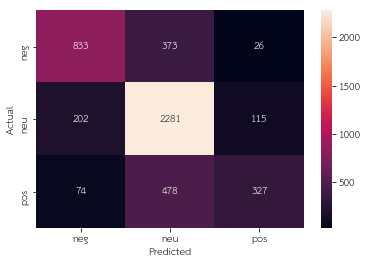

In [21]:
#confusion matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(probs_df.category,probs_df.preds)
print(model.score(X_valid,y_valid))
sns.heatmap(conf_mat, annot=True, fmt="d",
            xticklabels=model.classes_, yticklabels=model.classes_)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [22]:
#test the model
test_input = pd.DataFrame({"texts":["เราจะทำตามสัญญาขอเวลาอีกนิดนึงนะจ๊ะ"]})
test_input["processed"] = test_input.texts.map(lambda x: "|".join(process_thai(x)))
test_input["wc"] = test_input.processed.map(lambda x: len(x.split("|")))
test_input["uwc"] = test_input.processed.map(lambda x: len(set(x.split("|"))))

tf_input = tfidf_fit.transform(test_input["texts"])

num_input = scaler_fit.transform(test_input[["wc","uwc"]].astype(float))

t_input =  np.concatenate([num_input,tf_input.toarray()],axis=1)

output_pd = pd.DataFrame(model.predict_proba(t_input))
output_pd.columns = model.classes_
output_pd["pred"] = model.predict(t_input)
output_pd["texts"] = test_input.texts
output_pd["processed"] = test_input.processed
output_pd["wc"] = test_input.wc
output_pd["uwc"] = test_input.uwc

output_pd

,neg,neu,pos,pred,texts,processed,wc,uwc
0,0.382338,0.482164,0.135498,neu,เราจะทำตามสัญญาขอเวลาอีกนิดนึงนะจ๊ะ,เรา|จะ|ทำตาม|สัญญา|ขอเวลา|อีก|นิดนึง|นะจ๊ะ,8,8


In [25]:
#export model
import joblib
joblib.dump(model,'sent_model.pkl')
joblib.dump(tfidf_fit, 'tfidf_model.pkl')
joblib.dump(scaler_fit, 'scaler_model.pkl')

['scaler_model.pkl']